# Extraction and Test Metrics

In [ ]:
import os
import torch
import re
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.functional import cosinew_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


## Load the data

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
checkpoint_epoch_0 = '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0'
checkpoint_epoch_1 = '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293'
checkpoint_epoch_2 = '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586'
checkpoint_epoch_3 = '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879'
checkpoint_epoch_4 = '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172'
checkpoint_epoch_5 = '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465'
checkpoint_epoch_6 = '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758'
checkpoint_epoch_7 = '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051'
checkpoint_epoch_8 = '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344'
checkpoint_epoch_9 = '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637'
checkpoint_epoch_10 = '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-562930'

## Create helper functions

First, we define a helper class that we can use across all input embedding tests, to:


* Load the model
* Get the embedding for a word
* Get the cosine similarity between two words
* Get the top K-NN for a word  

In [18]:
class LTGBERT:
    def __init__(self, checkpoint_path: str, device: str = None):
        """
        Initialize the model and tokenizer from a given checkpoint path.
        """
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        print(f"Loading model from {checkpoint_path} on {self.device}...")
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
        self.model = AutoModel.from_pretrained(checkpoint_path).to(self.device)
        self.model.eval()

        # Cache the embedding matrix for nearest-neighbor search
        self.embedding_layer = self.model.get_input_embeddings()
        self.embedding_matrix = self.embedding_layer.weight.detach().cpu().numpy()
        self.vocab = self.tokenizer.get_vocab()
        self.id_to_token = {v: k for k, v in self.vocab.items()}

        print(f"Model and tokenizer loaded. Vocab size = {len(self.vocab)}")

    def get_embedding(self, word: str):
        """
        Get the embedding of a given word.
        If it consists of multiple tokens, returns the average embedding.
        Returns:
            embedding (np.ndarray): averaged embedding vector
            num_tokens (int): number of tokens
            tokens (list[str]): list of token strings
        """
        tokens = self.tokenizer.tokenize(word)
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        embeddings = self.embedding_layer.weight[token_ids].detach().cpu().numpy()
        avg_embedding = np.mean(embeddings, axis=0)
        return avg_embedding, len(tokens), tokens

    def get_cosine_similarity(self, word1: str, word2: str):
        """
        Compute cosine similarity between two words' embeddings.
        """
        emb1, _, _ = self.get_embedding(word1)
        emb2, _, _ = self.get_embedding(word2)
        emb1_t = torch.tensor(emb1)
        emb2_t = torch.tensor(emb2)
        similarity = F.cosine_similarity(emb1_t.unsqueeze(0), emb2_t.unsqueeze(0)).item()
        return similarity

    def get_top_k_nn(self, word: str, k: int = 10):
        """
        Get top-k nearest neighbors for a given word based on cosine similarity.
        For multi-token words, compares the averaged embedding to all vocab embeddings.
        Returns:
            List of tuples: [(neighbor_word, similarity), ...]
        """
        target_emb, _, _ = self.get_embedding(word)
        target_emb = torch.tensor(target_emb)

        # Compute cosine similarities to all embeddings in vocab
        emb_matrix_t = torch.tensor(self.embedding_matrix)
        similarities = F.cosine_similarity(target_emb.unsqueeze(0), emb_matrix_t, dim=1)

        # Get top-k excluding the word itself
        topk_vals, topk_idxs = torch.topk(similarities, k + 1)
        neighbors = []
        for sim, idx in zip(topk_vals.tolist(), topk_idxs.tolist()):
            token = self.id_to_token[idx]
            if token == word or token in self.tokenizer.all_special_tokens:
                continue
            neighbors.append((token, sim))
            if len(neighbors) >= k:
                break
        return neighbors


## Sanity check the data

Next, we perform a simple sanity check. We inspect the top-10 nearest neighbors of a target word over epochs, and inspect the cosine similarity between two target words over epochs.

In [19]:
def test_model(checkpoint_path):
    print("\n==============================")
    print(f"Testing model: {checkpoint_path}")
    print("==============================")

    # Load the model
    model = LTGBERT(checkpoint_path)

    # Test 1: Get embedding of word
    word = "language"
    emb, n_tokens, toks = model.get_embedding(word)
    print(f"Word: {word}")
    print(f"Tokens: {toks}")
    print(f"Num tokens: {n_tokens}")

    # Test 2: Cosine similarity between two words
    w1, w2 = "bank", "river"
    sim = model.get_cosine_similarity(w1, w2)
    print(f"\nCosine similarity between '{w1}' and '{w2}': {sim:.4f}")

    # Test 3: Top-K neighbors of word
    target_word = "bank"
    top_k = 10
    neighbors = model.get_top_k_nn(target_word, k=top_k)
    print(f"\nTop-{top_k} nearest neighbors for '{target_word}':")
    for i, (token, sim) in enumerate(neighbors, 1):
        print(f"{i:2d}. {token:15s}  {sim:.4f}")


# Run tests for a subset of checkpoints (you can extend this list)
for ckpt in [checkpoint_epoch_0, checkpoint_epoch_1, checkpoint_epoch_2, checkpoint_epoch_3, checkpoint_epoch_4, checkpoint_epoch_5, checkpoint_epoch_6, checkpoint_epoch_7, checkpoint_epoch_8, checkpoint_epoch_9, checkpoint_epoch_10]:
    test_model(ckpt)

Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing model: /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0 on cuda...
Model and tokenizer loaded. Vocab size = 16384
Word: language
Tokens: ['language']
Num tokens: 1

Cosine similarity between 'bank' and 'river': 0.0374

Top-10 nearest neighbors for 'bank':
 1. foreign          0.2882
 2. 1969             0.2749
 3. objective        0.2655
 4. via              0.2597
 5. ##fall           0.2585
 6. preparation      0.2569
 7. demand           0.2565
 8. candidates       0.2544
 9. ##ut             0.2538
10. existed          0.2507

Testing model: /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Word: language
Tokens: ['language']
Num tokens: 1

Cosine similarity between 'bank' and 'river': 0.1765

Top-10 nearest neighbors for 'bank':
 1. centre           0.3508
 2. denver           0.3370
 3. grounds          0.3236
 4. dakota           0.3212
 5. municipality     0.3172
 6. norwegian        0.3109
 7. municipal        0.3082
 8. brew             0.3068
 9. transportation   0.3063
10. stations         0.3016

Testing model: /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Word: language
Tokens: ['language']
Num tokens: 1

Cosine similarity between 'bank' and 'river': 0.2115

Top-10 nearest neighbors for 'bank':
 1. brew             0.3765
 2. dakota           0.3720
 3. suburb           0.3640
 4. constituency     0.3639
 5. sector           0.3632
 6. coast            0.3584
 7. centre           0.3524
 8. metropolitan     0.3412
 9. municipality     0.3384
10. borough          0.3366

Testing model: /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Word: language
Tokens: ['language']
Num tokens: 1

Cosine similarity between 'bank' and 'river': 0.2493

Top-10 nearest neighbors for 'bank':
 1. sector           0.4103
 2. coast            0.4037
 3. brew             0.3931
 4. branch           0.3884
 5. merger           0.3751
 6. constituency     0.3731
 7. financ           0.3704
 8. currency         0.3687
 9. borough          0.3678
10. dakota           0.3677

Testing model: /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Word: language
Tokens: ['language']
Num tokens: 1

Cosine similarity between 'bank' and 'river': 0.2639

Top-10 nearest neighbors for 'bank':
 1. sector           0.4303
 2. banks            0.4260
 3. currency         0.4236
 4. branch           0.4027
 5. coast            0.3993
 6. flank            0.3885
 7. brew             0.3810
 8. library          0.3737
 9. financ           0.3730
10. berlin           0.3726

Testing model: /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Word: language
Tokens: ['language']
Num tokens: 1

Cosine similarity between 'bank' and 'river': 0.3078

Top-10 nearest neighbors for 'bank':
 1. banks            0.4599
 2. currency         0.4554
 3. sector           0.4499
 4. coast            0.4267
 5. flank            0.4237
 6. branch           0.4155
 7. berlin           0.4000
 8. treasury         0.3993
 9. pole             0.3917
10. ##walk           0.3846

Testing model: /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Word: language
Tokens: ['language']
Num tokens: 1

Cosine similarity between 'bank' and 'river': 0.3146

Top-10 nearest neighbors for 'bank':
 1. banks            0.4954
 2. currency         0.4749
 3. sector           0.4635
 4. coast            0.4312
 5. flank            0.4265
 6. branch           0.4227
 7. berlin           0.4177
 8. treasury         0.4107
 9. constituency     0.4071
10. coalition        0.4029

Testing model: /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Word: language
Tokens: ['language']
Num tokens: 1

Cosine similarity between 'bank' and 'river': 0.3180

Top-10 nearest neighbors for 'bank':
 1. banks            0.5006
 2. currency         0.4835
 3. sector           0.4567
 4. berlin           0.4413
 5. coast            0.4399
 6. treasury         0.4330
 7. branch           0.4328
 8. flank            0.4289
 9. coalition        0.4115
10. dollar           0.4102

Testing model: /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Word: language
Tokens: ['language']
Num tokens: 1

Cosine similarity between 'bank' and 'river': 0.3152

Top-10 nearest neighbors for 'bank':
 1. banks            0.5113
 2. currency         0.5002
 3. sector           0.4657
 4. branch           0.4443
 5. flank            0.4405
 6. treasury         0.4394
 7. berlin           0.4388
 8. chamber          0.4270
 9. coast            0.4251
10. ##walk           0.4250

Testing model: /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-562930 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Word: language
Tokens: ['language']
Num tokens: 1

Cosine similarity between 'bank' and 'river': 0.3246

Top-10 nearest neighbors for 'bank':
 1. banks            0.5218
 2. currency         0.5108
 3. sector           0.4752
 4. flank            0.4515
 5. berlin           0.4483
 6. branch           0.4448
 7. treasury         0.4448
 8. coast            0.4382
 9. chamber          0.4375
10. ##walk           0.4296

Testing model: /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-562930
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-562930 on cuda...
Model and tokenizer loaded. Vocab size = 16384
Word: language
Tokens: ['language']
Num tokens: 1

Cosine similarity between 'bank' and 'river': 0.3239

Top-10 nearest neighbors for 'bank':
 1. banks            0.5239
 2. currency         0.5140
 3. sector           0.4755
 4. flank            0.4518
 5. berlin           0

Next, we define/load the dataset

In [20]:
mock_dataset = { 'target_words': [ { 'frequency_class': 'frequent',
                      'num_senses': 75,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'glen',
                                        'cafe',
                                        'stretched',
                                        'sur',
                                        'specimen',
                                        'god',
                                        'wrest',
                                        'fright',
                                        'dean',
                                        'cock'],
                      'similar_words': [ 'reveal',
                                         'decrease',
                                         'part',
                                         'out',
                                         'escape',
                                         'weaken',
                                         'delay',
                                         'hurt',
                                         'bog',
                                         'dash'],
                      'word': 'break'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 70,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'comedian',
                                        'slav',
                                        'facing',
                                        'unusually',
                                        'sent',
                                        'gibson',
                                        'posted',
                                        'suburb',
                                        'accidentally',
                                        'participation'],
                      'similar_words': [ 'stroke',
                                         'hob',
                                         'sever',
                                         'bore',
                                         'dock',
                                         'shank',
                                         'make',
                                         'tap',
                                         'create',
                                         'rip'],
                      'word': 'cut'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 52,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'openly',
                                        'concrete',
                                        'suit',
                                        'protestant',
                                        'hiv',
                                        'annoy',
                                        'approved',
                                        'tactical',
                                        'scoring',
                                        'leeds'],
                      'similar_words': [ 'whale',
                                         'try',
                                         'waste',
                                         'roll',
                                         'block',
                                         'double',
                                         'return',
                                         'operate',
                                         'show',
                                         'action'],
                      'word': 'running'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 52,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'lasting',
                                        'frequent',
                                        'gates',
                                        'goddess',
                                        'internal',
                                        'ten',
                                        'ray',
                                        'namely',
                                        'pose',
                                        'turnpike'],
                      'similar_words': [ 'assist',
                                         'hit',
                                         'bowl',
                                         'declare',
                                         'use',
                                         'activity',
                                         'go',
                                         'follow',
                                         'face',
                                         'bring'],
                      'word': 'play'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 51,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'received',
                                        'younger',
                                        'call',
                                        'organisation',
                                        'boycott',
                                        'advisory',
                                        'kin',
                                        'erupt',
                                        'temporary',
                                        'worth'],
                      'similar_words': [ 'write',
                                         'secure',
                                         'score',
                                         'work',
                                         'name',
                                         'pay',
                                         'mold',
                                         'incorporate',
                                         'cause',
                                         'piece'],
                      'word': 'make'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 50,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'deter',
                                        'width',
                                        'natural',
                                        'tactics',
                                        'auxiliary',
                                        'medic',
                                        'educated',
                                        'pepper',
                                        'smooth',
                                        'chief'],
                      'similar_words': [ 'superior',
                                         'raise',
                                         'effective',
                                         'good',
                                         'surpass',
                                         'improve',
                                         'reform',
                                         'relieve',
                                         'turn',
                                         'alter'],
                      'word': 'better'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 47,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'grandfather',
                                        'space',
                                        'presentation',
                                        'recognition',
                                        'paid',
                                        'casting',
                                        'initiative',
                                        'likely',
                                        'clinical',
                                        'seb'],
                      'similar_words': [ 'moon',
                                         'easy',
                                         'insight',
                                         'halo',
                                         'look',
                                         'match',
                                         'shaft',
                                         'lighting',
                                         'glory',
                                         'short'],
                      'word': 'light'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 46,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'complete',
                                        'theology',
                                        'atp',
                                        'apr',
                                        'typically',
                                        'wagner',
                                        'figure',
                                        'studying',
                                        'hill',
                                        'addition'],
                      'similar_words': [ 'descent',
                                         'change',
                                         'yield',
                                         'exit',
                                         'autumn',
                                         'flag',
                                         'occur',
                                         'come',
                                         'night',
                                         'get'],
                      'word': 'falls'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 45,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'feud',
                                        'affecting',
                                        'lind',
                                        'unified',
                                        'crew',
                                        'subsequent',
                                        'material',
                                        'button',
                                        'enterprise',
                                        'fully'],
                      'similar_words': [ 'clean',
                                         'create',
                                         'hop',
                                         'strip',
                                         'withdraw',
                                         'earn',
                                         'free',
                                         'sell',
                                         'settle',
                                         'clearly'],
                      'word': 'clear'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 36,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'copyright',
                                        'isn',
                                        'rivalry',
                                        'relieve',
                                        'say',
                                        'simply',
                                        'label',
                                        'definitely',
                                        'crisis',
                                        'missouri'],
                      'similar_words': [ 'capable',
                                         'breach',
                                         'display',
                                         'gap',
                                         'exterior',
                                         'exposed',
                                         'afford',
                                         'give',
                                         'grass',
                                         'jimmy'],
                      'word': 'open'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 8,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'theatre',
                                        'nato',
                                        'investigate',
                                        'packed',
                                        'billion',
                                        'agricultural',
                                        'nervous',
                                        'sad',
                                        'ion',
                                        'aggregate'],
                      'similar_words': [ 'help',
                                         'travel',
                                         'accommodate',
                                         'staff',
                                         'fill',
                                         'serve',
                                         'treat',
                                         'handle',
                                         'apply',
                                         'cater'],
                      'word': 'ply'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 7,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'clothes',
                                        'ranking',
                                        'airing',
                                        'inclusion',
                                        'follow',
                                        'load',
                                        'supply',
                                        'lineup',
                                        'teaching',
                                        'wanting'],
                      'similar_words': [ 'invent',
                                         'piece',
                                         'fix',
                                         'restore',
                                         'butterfly',
                                         'romance',
                                         'manufacture',
                                         'doctor',
                                         'backup',
                                         'patch'],
                      'word': 'vamp'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 6,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'developed',
                                        'precise',
                                        'attention',
                                        'destroy',
                                        'repair',
                                        'critically',
                                        'surprised',
                                        'empire',
                                        'minor',
                                        'peninsula'],
                      'similar_words': [ 'edge',
                                         'slope',
                                         'side',
                                         'bank',
                                         'talking',
                                         'pitch',
                                         'talk',
                                         'move',
                                         'cock',
                                         'slant'],
                      'word': 'cant'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 9,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'hub',
                                        'path',
                                        'increasing',
                                        'respect',
                                        'businessman',
                                        'bill',
                                        'goal',
                                        'mam',
                                        'prop',
                                        'atp'],
                      'similar_words': [ 'last',
                                         'break',
                                         'bust',
                                         'tucker',
                                         'hat',
                                         'dress',
                                         'exhaust',
                                         'wear',
                                         'assume',
                                         'decay'],
                      'word': 'weares'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 4,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'later',
                                        'damages',
                                        'amino',
                                        'exit',
                                        'pursuing',
                                        'oval',
                                        'wrest',
                                        'narrowly',
                                        'operational',
                                        'wrestling'],
                      'similar_words': [ 'position',
                                         'fix',
                                         'ready',
                                         'place',
                                         'pose',
                                         'bone',
                                         'drum',
                                         'lay',
                                         'put',
                                         'prepare'],
                      'word': 'crams'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 5,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'destruction',
                                        'pollution',
                                        'putting',
                                        'retail',
                                        'notable',
                                        'mainstream',
                                        'qualification',
                                        'regional',
                                        'twin',
                                        'reception'],
                      'similar_words': [ 'captive',
                                         'con',
                                         'argument',
                                         'prisoner',
                                         'learn',
                                         'sting',
                                         'rig',
                                         'short',
                                         'study',
                                         'rook'],
                      'word': 'cons'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 4,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'forward',
                                        'heard',
                                        'news',
                                        'inning',
                                        'house',
                                        'pow',
                                        'pale',
                                        'wonderful',
                                        'radiation',
                                        'broadway'],
                      'similar_words': [ 'vamp',
                                         'reconstruction',
                                         'point',
                                         'restoration',
                                         'restore',
                                         'fix',
                                         'improvement',
                                         'piece',
                                         'maintenance',
                                         'sole'],
                      'word': 'mend'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 3,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'short',
                                        'satisfied',
                                        'elder',
                                        'scenario',
                                        'energy',
                                        'rapid',
                                        'birth',
                                        'viewer',
                                        'membership',
                                        'hull'],
                      'similar_words': [ 'jazz',
                                         'play',
                                         'repeat',
                                         'riff',
                                         'tongue',
                                         'channel',
                                         'rag',
                                         'speak',
                                         'talk',
                                         'replay'],
                      'word': 'spiel'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 12,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'dozens',
                                        'dynamics',
                                        'statute',
                                        'baron',
                                        'later',
                                        'music',
                                        'check',
                                        'mating',
                                        'distinctive',
                                        'arrow'],
                      'similar_words': [ 'rub',
                                         'connect',
                                         'interference',
                                         'stop',
                                         'connection',
                                         'period',
                                         'catch',
                                         'halt',
                                         'walk',
                                         'stay'],
                      'word': 'hitch'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 5,
                      'polysemy_class': 'polysemous',
                      'random_words': [ 'saturday',
                                        'america',
                                        'reel',
                                        'same',
                                        'express',
                                        'baker',
                                        'picture',
                                        'fit',
                                        'ranking',
                                        'panzer'],
                      'similar_words': [ 'section',
                                         'country',
                                         'hub',
                                         'part',
                                         'region',
                                         'heart',
                                         'eye',
                                         'area',
                                         'place',
                                         'lay'],
                      'word': 'middles'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'moth',
                                        'arcade',
                                        'neutral',
                                        'striker',
                                        'holy',
                                        'participation',
                                        'anonymous',
                                        'plaza',
                                        'soviet',
                                        'corruption'],
                      'similar_words': [ 'singles',
                                         'doubles',
                                         'sport',
                                         'duo',
                                         'ball',
                                         'net',
                                         'court',
                                         'serve',
                                         'hit',
                                         'smash'],
                      'word': 'tennis'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'seriously',
                                        'role',
                                        'howard',
                                        'rarely',
                                        'withdrawal',
                                        'remove',
                                        'manufacture',
                                        'lebanon',
                                        'learn',
                                        'miss'],
                      'similar_words': [ 'assess',
                                         'recommend',
                                         'value',
                                         'laud',
                                         'measure',
                                         'proclaim',
                                         'promote',
                                         'praise',
                                         'push',
                                         'worship'],
                      'word': 'praised'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'engine',
                                        'cater',
                                        'failure',
                                        'resistance',
                                        'sought',
                                        'hands',
                                        'hindi',
                                        'fun',
                                        'graduation',
                                        'rap'],
                      'similar_words': [ 'slam',
                                         'sweep',
                                         'success',
                                         'conclusion',
                                         'win',
                                         'fall',
                                         'finish',
                                         'independence',
                                         'pin',
                                         'ending'],
                      'word': 'victory'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'minutes',
                                        'declare',
                                        'armenia',
                                        'prep',
                                        'liner',
                                        'revenge',
                                        'dry',
                                        'milton',
                                        'player',
                                        'august'],
                      'similar_words': [ 'hunt',
                                         'lodge',
                                         'society',
                                         'association',
                                         'order',
                                         'club',
                                         'chapter',
                                         'group',
                                         'union',
                                         'members'],
                      'word': 'guild'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 2,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'govern',
                                        'aggress',
                                        'problem',
                                        'dominant',
                                        'highly',
                                        'tai',
                                        'bog',
                                        'winning',
                                        'relatively',
                                        'glob'],
                      'similar_words': [ 'small',
                                         'tiny',
                                         'size',
                                         'scale',
                                         'magnitude',
                                         'compact',
                                         'micro',
                                         'part',
                                         'feature',
                                         'component'],
                      'word': 'mini'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'hamburg',
                                        'bedroom',
                                        'wound',
                                        'design',
                                        'burg',
                                        'gall',
                                        'advance',
                                        'cup',
                                        'insect',
                                        'direction'],
                      'similar_words': [ 'gain',
                                         'gross',
                                         'clear',
                                         'earn',
                                         'make',
                                         'realize',
                                         'profit',
                                         'revenue',
                                         'sales',
                                         'income'],
                      'word': 'grossing'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'heights',
                                        'decisive',
                                        'marching',
                                        'livestock',
                                        'rout',
                                        'founding',
                                        'western',
                                        'bind',
                                        'dreadnought',
                                        'cab'],
                      'similar_words': [ 'expressway',
                                         'bypass',
                                         'freeway',
                                         'route',
                                         'interstate',
                                         'road',
                                         'motorway',
                                         'pike',
                                         'car',
                                         'lane'],
                      'word': 'highway'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'skin',
                                        'titled',
                                        'denver',
                                        'singapore',
                                        'worth',
                                        'record',
                                        'boyfriend',
                                        'entering',
                                        'venture',
                                        'strain'],
                      'similar_words': [ 'beam',
                                         'send',
                                         'broadcast',
                                         'air',
                                         'communication',
                                         'live',
                                         'media',
                                         'screen',
                                         'anchor',
                                         'news'],
                      'word': 'televised'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 3,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'admired',
                                        'bright',
                                        'convoy',
                                        'immigration',
                                        'nation',
                                        'cold',
                                        'era',
                                        'edgar',
                                        'manifest',
                                        'course'],
                      'similar_words': [ 'assert',
                                         'supposed',
                                         'aver',
                                         'say',
                                         'maintain',
                                         'claim',
                                         'statement',
                                         'crime',
                                         'report',
                                         'victim'],
                      'word': 'alleged'},
                    { 'frequency_class': 'frequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'opener',
                                        'inspector',
                                        'elder',
                                        'surge',
                                        'warrior',
                                        'frontier',
                                        'richardson',
                                        'speculation',
                                        'emotional',
                                        'christ'],
                      'similar_words': [ 'most',
                                         'virtually',
                                         'nearly',
                                         'about',
                                         'near',
                                         'roughly',
                                         'approximately',
                                         'degree',
                                         'around',
                                         'closely'],
                      'word': 'almost'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'knife',
                                        'address',
                                        'tub',
                                        'soviet',
                                        'pomp',
                                        'barrier',
                                        'isolated',
                                        'petersburg',
                                        'passenger',
                                        'graham'],
                      'similar_words': [ 'curse',
                                         'statement',
                                         'public',
                                         'declaration',
                                         'reject',
                                         'report',
                                         'charges',
                                         'opinion',
                                         'criticism',
                                         'official'],
                      'word': 'denouncements'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'paper',
                                        'hughes',
                                        'legal',
                                        'watch',
                                        'reach',
                                        'commissioned',
                                        'stunt',
                                        'ended',
                                        'max',
                                        'commentary'],
                      'similar_words': [ 'lend',
                                         'interest',
                                         'loan',
                                         'property',
                                         'invest',
                                         'contract',
                                         'bank',
                                         'credit',
                                         'debt',
                                         'money'],
                      'word': 'mortgagee'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'organic',
                                        'mountain',
                                        'advance',
                                        'enemy',
                                        'passing',
                                        'formed',
                                        'revel',
                                        'olympics',
                                        'speculation',
                                        'vest'],
                      'similar_words': [ 'bang',
                                         'fuck',
                                         'jazz',
                                         'take',
                                         'bed',
                                         'love',
                                         'have',
                                         'pair',
                                         'mate',
                                         'know'],
                      'word': 'eff'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'sunderland',
                                        'slower',
                                        'interior',
                                        'maxim',
                                        'fond',
                                        'moore',
                                        'congress',
                                        'affected',
                                        'economy',
                                        'boxing'],
                      'similar_words': [ 'drugs',
                                         'chemical',
                                         'experiment',
                                         'doctor',
                                         'medicine',
                                         'company',
                                         'industry',
                                         'health',
                                         'laboratory',
                                         'trials'],
                      'word': 'pharmacologists'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'murray',
                                        'ignored',
                                        'sharing',
                                        'fire',
                                        'reserved',
                                        'committee',
                                        'website',
                                        'able',
                                        'portugal',
                                        'removal'],
                      'similar_words': [ 'body',
                                         'person',
                                         'flesh',
                                         'anatomy',
                                         'build',
                                         'frame',
                                         'figure',
                                         'shape',
                                         'form',
                                         'physical'],
                      'word': 'bod'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'driver',
                                        'colon',
                                        'wheeler',
                                        'zoo',
                                        'incident',
                                        'muse',
                                        'sandstone',
                                        'preserved',
                                        'inside',
                                        'sear'],
                      'similar_words': [ 'allow',
                                         'permit',
                                         'legitimate',
                                         'let',
                                         'authority',
                                         'law',
                                         'act',
                                         'statute',
                                         'license',
                                         'enact'],
                      'word': 'legalises'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'conscious',
                                        'volcanic',
                                        'technique',
                                        'alder',
                                        'care',
                                        'logo',
                                        'shield',
                                        'concert',
                                        'occupation',
                                        'size'],
                      'similar_words': [ 'meet',
                                         'fit',
                                         'benefit',
                                         'suit',
                                         'serve',
                                         'duty',
                                         'responsibility',
                                         'require',
                                         'advantage',
                                         'merit'],
                      'word': 'behoove'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'accomplished',
                                        'substitute',
                                        'participate',
                                        'fuller',
                                        'proportion',
                                        'cape',
                                        'lower',
                                        'chest',
                                        'beat',
                                        'fossil'],
                      'similar_words': [ 'alter',
                                         'change',
                                         'villain',
                                         'attack',
                                         'criticism',
                                         'abuse',
                                         'reputation',
                                         'character',
                                         'image',
                                         'opinion'],
                      'word': 'demonise'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'pointed',
                                        'jury',
                                        'mineral',
                                        'storey',
                                        'laying',
                                        'dynamics',
                                        'soph',
                                        'austria',
                                        'edition',
                                        'terrestrial'],
                      'similar_words': [ 'deal',
                                         'interact',
                                         'sell',
                                         'bank',
                                         'trade',
                                         'money',
                                         'partner',
                                         'machine',
                                         'buy',
                                         'goods'],
                      'word': 'transact'},
                    { 'frequency_class': 'infrequent',
                      'num_senses': 1,
                      'polysemy_class': 'monosemous',
                      'random_words': [ 'charter',
                                        'copper',
                                        'collapse',
                                        'laud',
                                        'studied',
                                        'calvin',
                                        'declare',
                                        'singing',
                                        'temperature',
                                        'confusion'],
                      'similar_words': [ 'hold',
                                         'view',
                                         'consider',
                                         'see',
                                         'regard',
                                         'judge',
                                         'believe',
                                         'mind',
                                         'thought',
                                         'rate'],
                      'word': 'deem'}]}

# The core metrics

We compute two metrics that describe one model checkpoint:

1. **Semantic separation** between:
- A target word and similar words.
- A target word and random words.
2. **Neighborhood density**: the average cosine similarity between a target word and its 10 nearest neighbors.


We compute two additional metrics that compare two subsequent model checkpoints:

1. **Embedding drift**: the absolute movement of a target word's input embedding, between two subsequent epochs.
2. **Stability value**: the overlap between the 10 nearest neighbors of a target word, between two subsequent epochs.

## Semantic separation

First, we compute semantic separation. To do so, we perform the following steps:
1. We compute the cosine similarity between a target word and 10 similar words.
2. We compute the cosine similarity between a target word and 10 random words.
3. For each target word, we take the average of its similarities with the similar words and the average of its similarities with the random words.
4. We define the *semantic separation score* as the difference between these two averages — that is, the mean similarity to similar words minus the mean similarity to random words.
5. This process is repeated for all target words at each training checkpoint.
6. Finally, we aggregate the results across checkpoints and analyze how semantic separation evolves over training, grouped by word frequency and polysemy class.

In [21]:
# --- 1. Load checkpoints ---
checkpoints = {
    0: '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0',
    1: '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293',
    2: '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586',
    3: '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879',
    4: '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172',
    5: '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465',
    6: '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758',
    7: '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051',
    8: '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344',
    9: '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637',
    10: '/content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-562930'
}

# --- 2. Define evaluation logic ---
def calculate_semantic_separation(model: LTGBERT, dataset: dict, top_k=10):
    """
    For each target word, compute:
      - avg similarity with its similar_words list
      - avg similarity with its random_words list
      - difference (semantic separation score)
    """
    results = []
    for entry in dataset["target_words"]:
        word = entry["word"]

        similar_sims = []
        random_sims = []

        # Similar group
        for sim_word in entry["similar_words"]:
            try:
                s = model.get_cosine_similarity(word, sim_word)
                similar_sims.append(s)
            except Exception:
                pass

        # Random group
        for rnd_word in entry["random_words"]:
            try:
                s = model.get_cosine_similarity(word, rnd_word)
                random_sims.append(s)
            except Exception:
                pass

        results.append({
            "word": word,
            "frequency_class": entry["frequency_class"],
            "polysemy_class": entry["polysemy_class"],
            "num_senses": entry["num_senses"],
            "avg_similar_sim": np.mean(similar_sims) if similar_sims else np.nan,
            "avg_random_sim": np.mean(random_sims) if random_sims else np.nan,
            "semantic_separation": (np.mean(similar_sims) - np.mean(random_sims))
                if (similar_sims and random_sims) else np.nan
        })
    return pd.DataFrame(results)

# --- 3. Run evaluation for all checkpoints ---
all_results = []
for epoch, path in checkpoints.items():
    print(f"\n--- Evaluating epoch {epoch} ---")
    model = LTGBERT(checkpoint_path=path)
    df = calculate_semantic_separation(model, mock_dataset)
    df["epoch"] = epoch
    all_results.append(df)

# --- 4. Combine and save ---
final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv("ltgbert_semantic_separation.csv", index=False)
print("✅ Saved results to ltgbert_semantic_separation.csv")

# --- 5. Example aggregation ---
agg = (
    final_df.groupby(["epoch", "frequency_class", "polysemy_class"])
    .agg({"semantic_separation": "mean"})
    .reset_index()
)
print("\nAverage semantic separation per group:\n", agg)



--- Evaluating epoch 0 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating epoch 1 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293 on cuda...
Model and tokenizer loaded. Vocab size = 16384


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating epoch 2 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586 on cuda...
Model and tokenizer loaded. Vocab size = 16384


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating epoch 3 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879 on cuda...
Model and tokenizer loaded. Vocab size = 16384


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating epoch 4 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172 on cuda...
Model and tokenizer loaded. Vocab size = 16384


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating epoch 5 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465 on cuda...
Model and tokenizer loaded. Vocab size = 16384


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating epoch 6 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758 on cuda...
Model and tokenizer loaded. Vocab size = 16384


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating epoch 7 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051 on cuda...
Model and tokenizer loaded. Vocab size = 16384

--- Evaluating epoch 8 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384

--- Evaluating epoch 9 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384

--- Evaluating epoch 10 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-562930 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-562930 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
✅ Saved results to ltgbert_semantic_separation.csv

Average semantic separation per group:
     epoch frequency_class polysemy_class  semantic_separation
0       0        frequent     monosemous            -0.007916
1       0        frequent     polysemous             0.031590
2       0      infrequent     monosemous            -0.068604
3       0      infrequent     polysemous            -0.023764
4       1        frequent     monosemous             0.030768
5       1        frequent     polysemous             0.053383
6       1      infrequent     monosemous            -0.054665
7       1      infrequent     polysemous            -0.019105
8       2        frequent     monosemous             0.069491
9       2        frequent     polysemous             0.064642
10      2      infrequent     monosemous            -0.018022
11      2      infrequent     polysemous            -0.008085
12      3        frequent     monosemous             0.

Next, we visualize the semantic separation for all 4 experimental conditions, epoch over epoch.

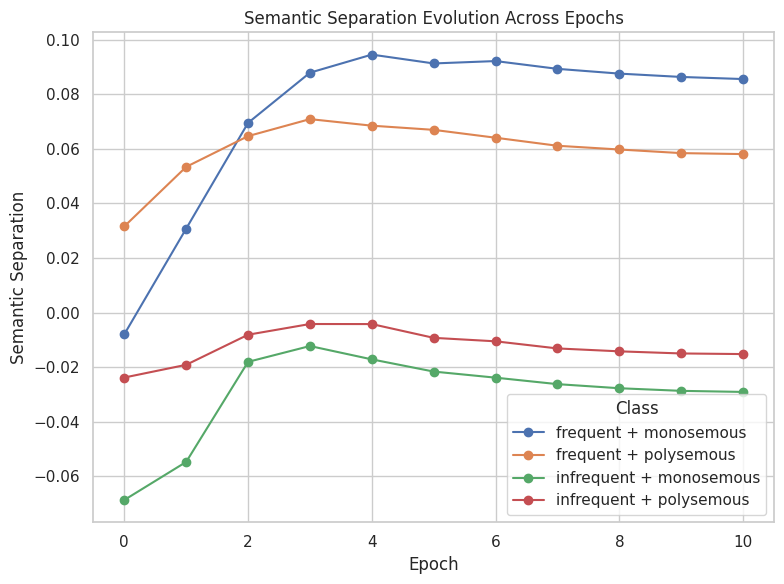

In [22]:
# --- 1. Create a new column combining frequency_class and polysemy_class ---
final_df["group"] = final_df["frequency_class"] + " + " + final_df["polysemy_class"]

# --- 2. Aggregate if needed ---
agg_df = (
    final_df.groupby(["epoch", "group"])
    .agg({"semantic_separation": "mean"})
    .reset_index()
)

# --- 3. Plot ---
plt.figure(figsize=(8,6))
sns.set(style="whitegrid")

for grp in agg_df["group"].unique():
    subset = agg_df[agg_df["group"] == grp]
    plt.plot(
        subset["epoch"],                # X-axis: epoch
        subset["semantic_separation"],  # Y-axis: separation
        marker="o",
        label=grp
    )

plt.xlabel("Epoch")
plt.ylabel("Semantic Separation")
plt.title("Semantic Separation Evolution Across Epochs")
plt.legend(title="Class")
plt.tight_layout()
plt.show()


## Neighborhood density

Then, we compute neighborhood density. To do so, we perform the following steps:
1. For each target word, we retrieve its top-10 nearest neighbors in the embedding space based on cosine similarity.
2. We then compute the average cosine similarity between the target word and its top-10 neighbors.
3. This average similarity represents the *neighborhood density* — a measure of how tightly clustered or diffuse a word’s local semantic region is.
4. Words with high neighborhood density have embeddings surrounded by many closely related words, whereas low-density words occupy sparser regions of the semantic space.
5. We repeat this process for all target words at each checkpoint throughout training.
6. Finally, we aggregate and visualize the results across epochs, grouped by word frequency and polysemy class, to observe how the compactness of local semantic neighborhoods evolves over time.


In [23]:
# --- Parameters ---
TOP_K = 10  # Number of neighbors for density calculation

# --- 1. Function to compute neighborhood density ---
def compute_neighborhood_density(model: LTGBERT, dataset: dict, top_k=TOP_K):
    """
    Compute the average cosine similarity between each target word
    and its top_k nearest neighbors (excluding itself and special tokens).
    """
    results = []
    for entry in dataset["target_words"]:
        word = entry["word"]
        try:
            neighbors = model.get_top_k_nn(word, k=top_k)
            if neighbors:
                avg_density = np.mean([sim for _, sim in neighbors])
            else:
                avg_density = np.nan
        except Exception:
            avg_density = np.nan

        results.append({
            "word": word,
            "frequency_class": entry["frequency_class"],
            "polysemy_class": entry["polysemy_class"],
            "num_senses": entry["num_senses"],
            "neighborhood_density": avg_density
        })
    return pd.DataFrame(results)

# --- 2. Loop over checkpoints and compute densities ---
all_density_results = []
for epoch, path in checkpoints.items():
    print(f"\n--- Computing neighborhood density for epoch {epoch} ---")
    model = LTGBERT(checkpoint_path=path)
    df = compute_neighborhood_density(model, mock_dataset)
    df["epoch"] = epoch
    all_density_results.append(df)

# --- 3. Combine results ---
density_df = pd.concat(all_density_results, ignore_index=True)
density_df.to_csv("ltgbert_neighborhood_density.csv", index=False)
print("✅ Saved neighborhood density results to ltgbert_neighborhood_density.csv")

# --- 4. Aggregate by condition ---
agg_density = (
    density_df.groupby(["epoch", "frequency_class", "polysemy_class"])
    .agg({"neighborhood_density": "mean"})
    .reset_index()
)

# --- 5. Plotting ---
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create a "condition" column for easy plotting
agg_density["condition"] = agg_density["frequency_class"] + " | " + agg_density["polysemy_class"]

sns.lineplot(
    data=agg_density,
    x="epoch",
    y="neighborhood_density",
    hue="condition",
    marker="o"
)
plt.title(f"Neighborhood Density Evolution Across Checkpoints (Top-{TOP_K} neighbors)")
plt.xlabel("Epoch")
plt.ylabel("Average Neighborhood Density (cosine similarity)")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Computing neighborhood density for epoch 0 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0 on cuda...
Model and tokenizer loaded. Vocab size = 16384


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Computing neighborhood density for epoch 1 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293 on cuda...
Model and tokenizer loaded. Vocab size = 16384


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Computing neighborhood density for epoch 2 ---
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586 on cuda...
Model and tokenizer loaded. Vocab size = 16384


KeyboardInterrupt: 

## Embedding drift

We also compute embedding drift. To do so, we perform the following steps:
1. For each pair of consecutive checkpoints, we extract the embedding vector of every target word from both models.
2. We compute the cosine similarity between the embeddings of the same word across the two checkpoints.
3. This similarity measures *embedding drift*: higher values indicate that the word’s embedding has remained relatively stable, while lower values indicate that it has changed more during training.
4. We repeat this process for all target words and all consecutive checkpoint pairs.
5. Finally, we aggregate the results by word frequency and polysemy class to analyze which types of words undergo more or less change in their representations over training.



Computing embedding drift between epoch 0 and 1...
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384

Computing embedding drift between epoch 1 and 2...
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384

Computing embedding drift between epoch 2 and 3...
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384

Computing embedding drift between epoch 3 and 4...
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384

Computing embedding drift between epoch 4 and 5...
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465 on cuda...
Model and tokenizer loaded. Vocab size = 16384

Computing embedding drift between epoch 5 and 6...
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384

Computing embedding drift between epoch 6 and 7...
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051 on cuda...
Model and tokenizer loaded. Vocab size = 16384

Computing embedding drift between epoch 7 and 8...
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384

Computing embedding drift between epoch 8 and 9...
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637 on cuda...
Model and tokenizer loaded. Vocab size = 16384

Computing embedding drift between epoch 9 and 10...
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637 on cuda...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-562930 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded. Vocab size = 16384
Loading model from /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-562930 on cuda...
Model and tokenizer loaded. Vocab size = 16384
✅ Saved embedding drift results to ltgbert_embedding_drift.csv


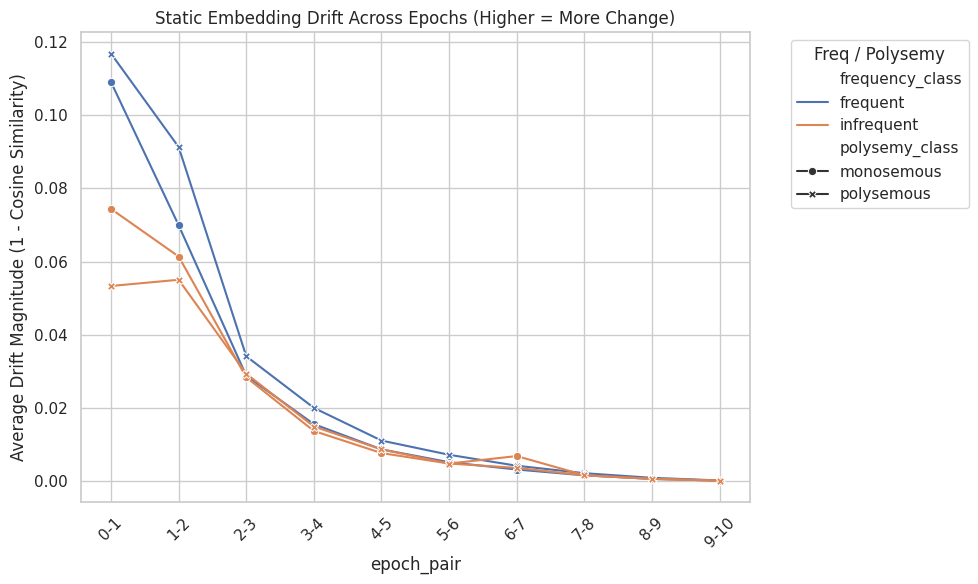

In [37]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Function to compute embedding drift between two checkpoints ---
def compute_embedding_drift(model1: LTGBERT, model2: LTGBERT, target_words: list):
    """
    Computes drift magnitude (1 - cosine similarity) between embeddings
    of the same word in two consecutive checkpoints.
    Returns:
        DataFrame with columns: word, frequency_class, polysemy_class, drift_magnitude
    """
    rows = []
    for entry in target_words:
        word = entry["word"]
        freq_class = entry["frequency_class"]
        poly_class = entry["polysemy_class"]
        try:
            emb1, _, _ = model1.get_embedding(word)
            emb2, _, _ = model2.get_embedding(word)
            # Cosine similarity between embeddings
            sim = F.cosine_similarity(
                torch.tensor(emb1).unsqueeze(0),
                torch.tensor(emb2).unsqueeze(0)
            ).item()
            drift = 1 - sim
        except Exception:
            drift = np.nan

        rows.append({
            "word": word,
            "frequency_class": freq_class,
            "polysemy_class": poly_class,
            "drift_magnitude": drift
        })
    return pd.DataFrame(rows)


# --- 2. Compute embedding drift across consecutive checkpoints ---
embedding_drift_results = []
epochs = sorted(checkpoints.keys())

for i in range(len(epochs) - 1):
    epoch_a = epochs[i]
    epoch_b = epochs[i + 1]

    print(f"\nComputing embedding drift between epoch {epoch_a} and {epoch_b}...")
    model_a = LTGBERT(checkpoint_path=checkpoints[epoch_a])
    model_b = LTGBERT(checkpoint_path=checkpoints[epoch_b])

    df_drift = compute_embedding_drift(model_a, model_b, mock_dataset["target_words"])
    df_drift["epoch_pair"] = f"{epoch_a}-{epoch_b}"
    embedding_drift_results.append(df_drift)


# --- 3. Combine results ---
embedding_drift_df = pd.concat(embedding_drift_results, ignore_index=True)
embedding_drift_df.to_csv("ltgbert_embedding_drift.csv", index=False)
print("✅ Saved embedding drift results to ltgbert_embedding_drift.csv")


# --- 4. Aggregate by condition ---
agg_drift = (
    embedding_drift_df.groupby(["epoch_pair", "frequency_class", "polysemy_class"])
    .agg({"drift_magnitude": "mean"})
    .reset_index()
)


# --- 5. Plotting ---
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=agg_drift,
    x="epoch_pair",
    y="drift_magnitude",
    hue="frequency_class",
    style="polysemy_class",
    markers=True,
    dashes=False
)
plt.xticks(rotation=45)
plt.ylabel("Average Drift Magnitude (1 - Cosine Similarity)")
plt.title("Static Embedding Drift Across Epochs (Higher = More Change)")
plt.legend(title="Freq / Polysemy", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Stability value

Next, we compute embedding *stability values*. To do so, we perform the following steps:
1. For each pair of consecutive checkpoints, we extract the top-10 nearest neighbors of every target word based on cosine similarity in the embedding space.
2. For the same word across the two checkpoints, we compute the overlap between these two neighbor sets.
3. The degree of overlap is measured using the Jaccard similarity — that is, the proportion of shared neighbors among the top-10 lists.
4. This overlap score represents the *stability* of the word’s embedding: higher values indicate that the word’s local semantic neighborhood remains consistent across training epochs.
5. We repeat this process for all target words and all consecutive checkpoint pairs.
6. Finally, we aggregate stability scores by word frequency and polysemy class to analyze which types of words exhibit more or less stable representations over time.


In [ ]:
# --- 1. Define function to compute stability between two checkpoints ---
def compute_stability(model1: LTGBERT, model2: LTGBERT, target_words: list, k: int = 10):
    """
    Computes top-k neighbor overlap (Jaccard similarity) between two models for each word.
    Returns:
        DataFrame with columns: word, frequency_class, polysemy_class, stability
    """
    rows = []
    for entry in target_words:
        word = entry["word"]
        freq_class = entry["frequency_class"]
        poly_class = entry["polysemy_class"]

        try:
            nn1 = [w for w, _ in model1.get_top_k_nn(word, k)]
            nn2 = [w for w, _ in model2.get_top_k_nn(word, k)]
            overlap = len(set(nn1).intersection(nn2)) / k  # proportion of overlap
        except Exception:
            overlap = np.nan

        rows.append({
            "word": word,
            "frequency_class": freq_class,
            "polysemy_class": poly_class,
            "stability": overlap
        })
    return pd.DataFrame(rows)

# --- 2. Compute stability across consecutive checkpoints ---
stability_results = []
epochs = sorted(checkpoints.keys())

for i in range(len(epochs) - 1):
    epoch_a = epochs[i]
    epoch_b = epochs[i + 1]

    print(f"\nComputing stability between epoch {epoch_a} and {epoch_b}...")
    model_a = LTGBERT(checkpoint_path=checkpoints[epoch_a])
    model_b = LTGBERT(checkpoint_path=checkpoints[epoch_b])

    df_stab = compute_stability(model_a, model_b, mock_dataset["target_words"], k=10)
    df_stab["epoch_pair"] = f"{epoch_a}-{epoch_b}"
    stability_results.append(df_stab)

# --- 3. Combine results ---
stability_df = pd.concat(stability_results, ignore_index=True)
stability_df.to_csv("ltgbert_embedding_stability.csv", index=False)
print("✅ Saved stability results to ltgbert_embedding_stability.csv")

# --- 4. Aggregate by condition ---
agg_stability = (
    stability_df.groupby(["epoch_pair", "frequency_class", "polysemy_class"])
    .agg({"stability": "mean"})
    .reset_index()
)

# --- 5. Plotting ---
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=agg_stability,
    x="epoch_pair",
    y="stability",
    hue="frequency_class",
    style="polysemy_class",
    markers=True,
    dashes=False
)
plt.xticks(rotation=45)
plt.ylabel("Average Top-10 Neighbor Stability")
plt.title("Embedding Stability Across Epochs")
plt.legend(title="Freq / Polysemy", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Cross-metric comparisons

### Stability versus embedding drift

Both metrics measure embedding consistency across epochs, but at different levels:
- **Stability** measures the relative semantic change: do the closest words remain the same?
- **Drift** measures the absolute change of the embedding vector: is the word’s position in the embedding space preserved?


# Contextualized embedding metrics

In [24]:
class ContextualEmbedder:
    def __init__(self, checkpoint_path):
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
        self.model = AutoModel.from_pretrained(checkpoint_path, output_hidden_states=True)
        self.model.eval()

    def get_contextual_embedding(self, sentence, target_word):
        """Return mean of all subtoken embeddings of target_word in the last layer."""
        tokens = self.tokenizer(sentence, return_tensors='pt')
        with torch.no_grad():
            outputs = self.model(**tokens)
        last_hidden = outputs.last_hidden_state.squeeze(0)  # shape: [seq_len, hidden_dim]
        tokenized = self.tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])

        # Find subtoken indices corresponding to target_word
        word_pieces = self.tokenizer.tokenize(target_word)
        indices = []
        for i in range(len(tokenized) - len(word_pieces) + 1):
            if tokenized[i:i+len(word_pieces)] == word_pieces:
                indices.extend(range(i, i + len(word_pieces)))

        if not indices:
            return None  # Word not found

        emb = last_hidden[indices].mean(dim=0)  # Average over subword tokens
        return emb.cpu().numpy()

    def get_average_embedding(self, target_word, contexts, max_contexts=20):
        """Average contextual embeddings across multiple sentences."""
        embeddings = []
        for sent in contexts[:max_contexts]:
            emb = self.get_contextual_embedding(sent, target_word)
            if emb is not None:
                embeddings.append(emb)
        if not embeddings:
            return None
        return np.mean(embeddings, axis=0)

In [25]:
from transformers import AutoTokenizer

dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="train")
texts = [line for line in dataset["text"] if line.strip()]
tokenizer = AutoTokenizer.from_pretrained(checkpoints[0])

def collect_contexts_for_word(word, texts, max_contexts=20, max_length=512):
    contexts = []
    for line in texts:
        if f" {word} " in line.lower():
            num_tokens = len(tokenizer.tokenize(line))
            if num_tokens <= max_length:
                contexts.append(line.strip())
        if len(contexts) >= max_contexts:
            break
    return contexts


README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [26]:
context_bank = {w["word"]: collect_contexts_for_word(w["word"], texts)
                for w in mock_dataset["target_words"]}

In [27]:
contextual_results = []

for epoch, path in checkpoints.items():
    print(f"\nExtracting contextual embeddings for epoch {epoch}...")
    model = ContextualEmbedder(checkpoint_path=path)

    for entry in mock_dataset["target_words"]:
        word = entry["word"]
        contexts = context_bank.get(word, [])
        emb = model.get_average_embedding(word, contexts)

        if emb is not None:
            contextual_results.append({
                "epoch": epoch,
                "word": word,
                "frequency_class": entry["frequency_class"],
                "polysemy_class": entry["polysemy_class"],
                "embedding": emb
            })


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-0 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Extracting contextual embeddings for epoch 0...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-56293 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Extracting contextual embeddings for epoch 1...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-112586 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Extracting contextual embeddings for epoch 2...

Extracting contextual embeddings for epoch 3...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-168879 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-225172 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Extracting contextual embeddings for epoch 4...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-281465 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Extracting contextual embeddings for epoch 5...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-337758 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Extracting contextual embeddings for epoch 6...

Extracting contextual embeddings for epoch 7...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-394051 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-450344 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Extracting contextual embeddings for epoch 8...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-506637 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Extracting contextual embeddings for epoch 9...


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/ltgbert-wikitext103-(4e-5)-checkpoints/checkpoint-562930 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Extracting contextual embeddings for epoch 10...


In [28]:
import pandas as pd
contextual_df = pd.DataFrame(contextual_results)
contextual_df.to_pickle("ltgbert_contextual_embeddings.pkl")

Inspect the averaged contextual embeddings for the words.

In [29]:
contextual_df.head(50)

,epoch,word,frequency_class,polysemy_class,embedding
0,0,break,frequent,polysemous,"[-0.40599075, -1.6069429, 0.011032882, 0.51617..."
1,0,cut,frequent,polysemous,"[-0.39292285, 0.13279453, -0.833391, -0.510354..."
2,0,running,frequent,polysemous,"[1.0069138, -0.81156224, -0.688282, -0.3549956..."
3,0,play,frequent,polysemous,"[0.45818973, -0.01774333, 0.04509636, -0.00705..."
4,0,make,frequent,polysemous,"[0.84783924, -1.1119354, 0.055158604, 0.212731..."
5,0,better,frequent,polysemous,"[0.9964612, 0.4805333, 0.2081848, -0.6451297, ..."
6,0,light,frequent,polysemous,"[0.5976732, -0.4469294, 0.6447061, 0.16283645,..."
7,0,falls,frequent,polysemous,"[-0.5837084, -0.081491314, 0.45489472, 2.18265..."
8,0,clear,frequent,polysemous,"[-1.086737, -0.70330393, -0.17338802, 0.278957..."
9,0,open,frequent,polysemous,"[0.63624847, -0.13329583, -0.7253452, -0.20351..."


In [30]:
class ContextualLTGBERT:
    def __init__(self, contextual_df, epoch):
        """
        A lightweight wrapper that mimics LTGBERT but uses contextual embeddings.
        """
        self.embeddings = {
            row.word: np.array(row.embedding)
            for _, row in contextual_df[contextual_df["epoch"] == epoch].iterrows()
        }
        self.words = list(self.embeddings.keys())
        self.embedding_matrix = np.vstack(list(self.embeddings.values()))
        self.word_to_idx = {w: i for i, w in enumerate(self.words)}

    def get_embedding(self, word):
        """
        Get the averaged contextualized embedding for a given word.
        Returns:
            embedding (np.ndarray), num_tokens (int=1), tokens ([word])
        """
        return self.embeddings[word], 1, [word]

    def get_cosine_similarity(self, word1, word2):
        """
        Compute cosine similarity between two contextualized embeddings.
        """
        emb1 = torch.tensor(self.embeddings[word1])
        emb2 = torch.tensor(self.embeddings[word2])
        return F.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()

    def get_top_k_nn(self, word, k=10):
        """
        Compute top-k nearest neighbors among contextualized words only.
        """
        target_emb = torch.tensor(self.embeddings[word])
        matrix_t = torch.tensor(self.embedding_matrix)
        similarities = F.cosine_similarity(target_emb.unsqueeze(0), matrix_t, dim=1)

        topk_vals, topk_idxs = torch.topk(similarities, k + 1)
        neighbors = []
        for sim, idx in zip(topk_vals.tolist(), topk_idxs.tolist()):
            token = self.words[idx]
            if token == word:
                continue
            neighbors.append((token, sim))
            if len(neighbors) >= k:
                break
        return neighbors


## Embedding drift


Computing contextual embedding drift between epoch 0 and 1...

Computing contextual embedding drift between epoch 1 and 2...

Computing contextual embedding drift between epoch 2 and 3...

Computing contextual embedding drift between epoch 3 and 4...

Computing contextual embedding drift between epoch 4 and 5...

Computing contextual embedding drift between epoch 5 and 6...

Computing contextual embedding drift between epoch 6 and 7...

Computing contextual embedding drift between epoch 7 and 8...

Computing contextual embedding drift between epoch 8 and 9...

Computing contextual embedding drift between epoch 9 and 10...
✅ Saved contextual embedding drift results to ltgbert_contextual_embedding_drift.csv


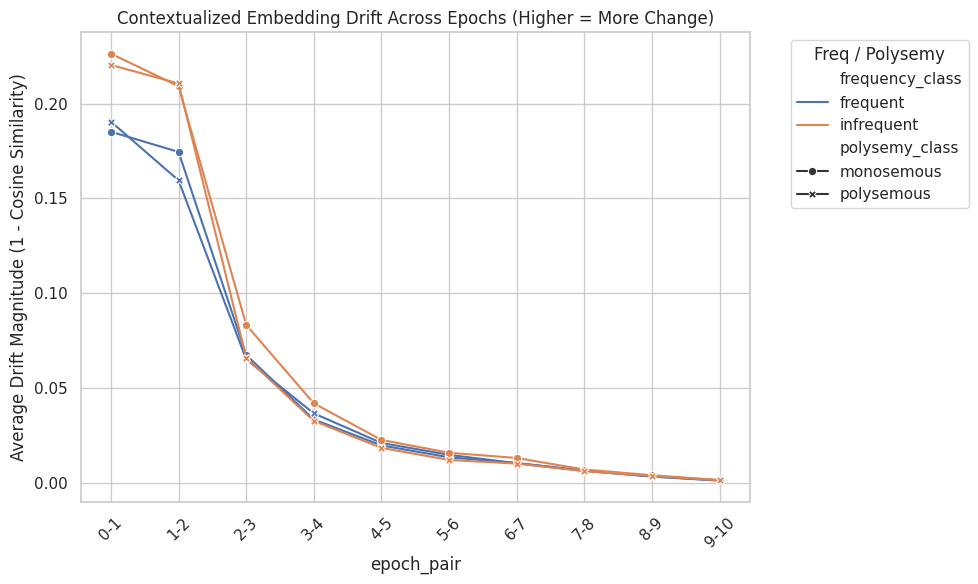

In [35]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Function to compute contextual embedding drift between two epochs ---
def compute_contextual_embedding_drift(model1, model2, target_words):
    """
    Computes drift magnitude (1 - cosine similarity) between averaged contextual embeddings
    of the same word across two consecutive epochs.

    Returns:
        DataFrame with columns:
        [word, frequency_class, polysemy_class, drift_magnitude]
    """
    rows = []
    for entry in target_words:
        word = entry["word"]
        freq_class = entry["frequency_class"]
        poly_class = entry["polysemy_class"]

        try:
            emb1, _, _ = model1.get_embedding(word)
            emb2, _, _ = model2.get_embedding(word)
            sim = F.cosine_similarity(
                torch.tensor(emb1).unsqueeze(0),
                torch.tensor(emb2).unsqueeze(0)
            ).item()
            drift = 1 - sim
        except Exception:
            drift = np.nan

        rows.append({
            "word": word,
            "frequency_class": freq_class,
            "polysemy_class": poly_class,
            "drift_magnitude": drift
        })

    return pd.DataFrame(rows)


# --- 2. Compute contextual embedding drift across consecutive epochs ---
contextual_embedding_drift_results = []
epochs = sorted(contextual_df["epoch"].unique())

for i in range(len(epochs) - 1):
    epoch_a = epochs[i]
    epoch_b = epochs[i + 1]

    print(f"\nComputing contextual embedding drift between epoch {epoch_a} and {epoch_b}...")
    model_a = ContextualLTGBERT(contextual_df, epoch_a)
    model_b = ContextualLTGBERT(contextual_df, epoch_b)

    df_drift = compute_contextual_embedding_drift(model_a, model_b, mock_dataset["target_words"])
    df_drift["epoch_pair"] = f"{epoch_a}-{epoch_b}"
    contextual_embedding_drift_results.append(df_drift)


# --- 3. Combine results ---
contextual_embedding_drift_df = pd.concat(contextual_embedding_drift_results, ignore_index=True)
contextual_embedding_drift_df.to_csv("ltgbert_contextual_embedding_drift.csv", index=False)
print("✅ Saved contextual embedding drift results to ltgbert_contextual_embedding_drift.csv")


# --- 4. Aggregate by condition ---
agg_contextual_drift = (
    contextual_embedding_drift_df.groupby(["epoch_pair", "frequency_class", "polysemy_class"])
    .agg({"drift_magnitude": "mean"})
    .reset_index()
)


# --- 5. Plotting ---
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=agg_contextual_drift,
    x="epoch_pair",
    y="drift_magnitude",
    hue="frequency_class",
    style="polysemy_class",
    markers=True,
    dashes=False
)
plt.xticks(rotation=45)
plt.ylabel("Average Drift Magnitude (1 - Cosine Similarity)")
plt.title("Contextualized Embedding Drift Across Epochs (Higher = More Change)")
plt.legend(title="Freq / Polysemy", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Stability value


Computing contextual stability between epoch 0 and 1...

Computing contextual stability between epoch 1 and 2...

Computing contextual stability between epoch 2 and 3...

Computing contextual stability between epoch 3 and 4...

Computing contextual stability between epoch 4 and 5...

Computing contextual stability between epoch 5 and 6...

Computing contextual stability between epoch 6 and 7...

Computing contextual stability between epoch 7 and 8...

Computing contextual stability between epoch 8 and 9...

Computing contextual stability between epoch 9 and 10...
✅ Saved contextual embedding stability results to ltgbert_contextual_embedding_stability.csv


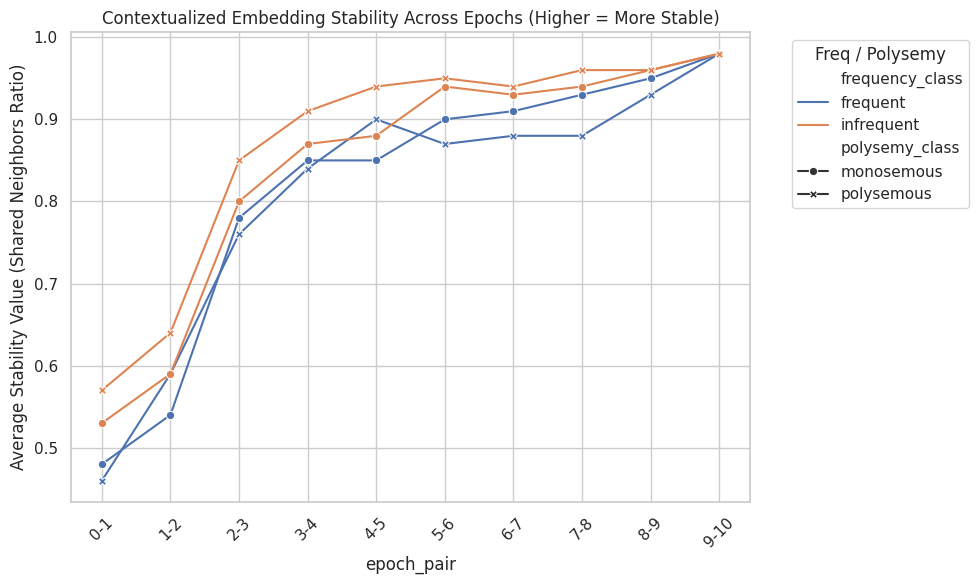

In [39]:
# --- 1. Function to compute contextual embedding stability between two epochs ---
def compute_contextual_embedding_stability(model1, model2, target_words, k=10):
    """
    Computes stability value between averaged contextual embeddings
    of the same word across two consecutive epochs.
    Stability = |shared top-k neighbors| / k

    Returns:
        DataFrame with columns:
        [word, frequency_class, polysemy_class, stability_value]
    """
    rows = []
    for entry in target_words:
        word = entry["word"]
        freq_class = entry["frequency_class"]
        poly_class = entry["polysemy_class"]

        try:
            # Ensure the word exists in both epochs
            if word not in model1.embeddings or word not in model2.embeddings:
                raise KeyError(f"{word} missing from embeddings")

            # Compute top-k neighbors in each model
            nn1 = [w for w, _ in model1.get_top_k_nn(word, k=k)]
            nn2 = [w for w, _ in model2.get_top_k_nn(word, k=k)]

            # Intersection-based stability
            shared = len(set(nn1) & set(nn2))
            stability = shared / k

        except Exception:
            stability = np.nan

        rows.append({
            "word": word,
            "frequency_class": freq_class,
            "polysemy_class": poly_class,
            "stability_value": stability
        })

    return pd.DataFrame(rows)


# --- 2. Compute contextual embedding stability across consecutive epochs ---
contextual_stability_results = []
epochs = sorted(contextual_df["epoch"].unique())

for i in range(len(epochs) - 1):
    epoch_a = epochs[i]
    epoch_b = epochs[i + 1]

    print(f"\nComputing contextual stability between epoch {epoch_a} and {epoch_b}...")
    model_a = ContextualLTGBERT(contextual_df, epoch_a)
    model_b = ContextualLTGBERT(contextual_df, epoch_b)

    df_stab = compute_contextual_embedding_stability(model_a, model_b, mock_dataset["target_words"], k=10)
    df_stab["epoch_pair"] = f"{epoch_a}-{epoch_b}"
    contextual_stability_results.append(df_stab)


# --- 3. Combine results ---
contextual_stability_df = pd.concat(contextual_stability_results, ignore_index=True)
contextual_stability_df.to_csv("ltgbert_contextual_embedding_stability.csv", index=False)
print("✅ Saved contextual embedding stability results to ltgbert_contextual_embedding_stability.csv")


# --- 4. Aggregate by condition ---
agg_stability = (
    contextual_stability_df.groupby(["epoch_pair", "frequency_class", "polysemy_class"])
    .agg({"stability_value": "mean"})
    .reset_index()
)


# --- 5. Plotting ---
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=agg_stability,
    x="epoch_pair",
    y="stability_value",
    hue="frequency_class",
    style="polysemy_class",
    markers=True,
    dashes=False
)
plt.xticks(rotation=45)
plt.ylabel("Average Stability Value (Shared Neighbors Ratio)")
plt.title("Contextualized Embedding Stability Across Epochs (Higher = More Stable)")
plt.legend(title="Freq / Polysemy", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Neighborhood density


--- Computing contextual neighborhood density for epoch 0 ---

--- Computing contextual neighborhood density for epoch 1 ---

--- Computing contextual neighborhood density for epoch 2 ---

--- Computing contextual neighborhood density for epoch 3 ---

--- Computing contextual neighborhood density for epoch 4 ---

--- Computing contextual neighborhood density for epoch 5 ---

--- Computing contextual neighborhood density for epoch 6 ---

--- Computing contextual neighborhood density for epoch 7 ---

--- Computing contextual neighborhood density for epoch 8 ---

--- Computing contextual neighborhood density for epoch 9 ---

--- Computing contextual neighborhood density for epoch 10 ---
✅ Saved contextual neighborhood density results to ltgbert_contextual_neighborhood_density.csv


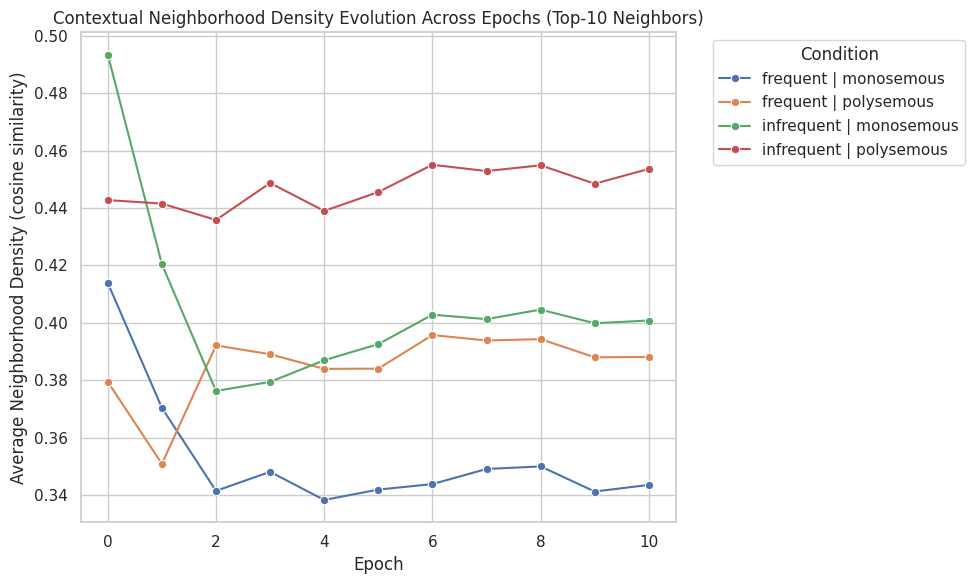

In [40]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

TOP_K = 10  # number of nearest neighbors

# --- 1. Function to compute contextual neighborhood density ---
def compute_contextual_neighborhood_density(model, dataset, top_k=TOP_K):
    """
    Compute the average cosine similarity between each target word's
    averaged contextual embedding and its top_k nearest neighbors
    in the contextual embedding space.

    Args:
        model (ContextualLTGBERT): contextual embedding wrapper for a given epoch
        dataset (dict): dataset with target_words
        top_k (int): number of nearest neighbors to consider

    Returns:
        DataFrame with columns:
            [word, frequency_class, polysemy_class, num_senses, neighborhood_density]
    """
    results = []

    for entry in dataset["target_words"]:
        word = entry["word"]
        try:
            neighbors = model.get_top_k_nn(word, k=top_k)
            if neighbors:
                avg_density = np.mean([sim for _, sim in neighbors])
            else:
                avg_density = np.nan
        except Exception:
            avg_density = np.nan

        results.append({
            "word": word,
            "frequency_class": entry["frequency_class"],
            "polysemy_class": entry["polysemy_class"],
            "num_senses": entry.get("num_senses", np.nan),
            "neighborhood_density": avg_density
        })

    return pd.DataFrame(results)


# --- 2. Loop over epochs and compute densities ---
contextual_density_results = []

for epoch in sorted(contextual_df["epoch"].unique()):
    print(f"\n--- Computing contextual neighborhood density for epoch {epoch} ---")
    model = ContextualLTGBERT(contextual_df, epoch)
    df = compute_contextual_neighborhood_density(model, mock_dataset, top_k=TOP_K)
    df["epoch"] = epoch
    contextual_density_results.append(df)


# --- 3. Combine results ---
contextual_density_df = pd.concat(contextual_density_results, ignore_index=True)
contextual_density_df.to_csv("ltgbert_contextual_neighborhood_density.csv", index=False)
print("✅ Saved contextual neighborhood density results to ltgbert_contextual_neighborhood_density.csv")


# --- 4. Aggregate by condition ---
agg_contextual_density = (
    contextual_density_df.groupby(["epoch", "frequency_class", "polysemy_class"])
    .agg({"neighborhood_density": "mean"})
    .reset_index()
)

# Add a combined condition label
agg_contextual_density["condition"] = (
    agg_contextual_density["frequency_class"] + " | " + agg_contextual_density["polysemy_class"]
)


# --- 5. Plotting ---
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.lineplot(
    data=agg_contextual_density,
    x="epoch",
    y="neighborhood_density",
    hue="condition",
    marker="o"
)
plt.title(f"Contextual Neighborhood Density Evolution Across Epochs (Top-{TOP_K} Neighbors)")
plt.xlabel("Epoch")
plt.ylabel("Average Neighborhood Density (cosine similarity)")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
